# A Simple Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled dataset.

In [4]:
import sys
sys.path.insert(1, "/kaggle/input/auto-encode")
import helpers

In [13]:
#!pip install -r "/kaggle/input/auto-encode/requirements.txt" | grep -v "already"

In [15]:
!pip install opencv-python-headless
!pip install matplotlib
!pip install numpy==1.21.2
!pip install pillow==7.0.0
!pip install bokeh==2.1.1
!pip install torch==1.11.0
!pip install torchvision==0.12.0
!pip install tqdm==4.63.0
!pip install ipywidgets==7.6.5
!pip install livelossplot==0.5.4
!pip install pytest==7.1.1
!pip install pandas==1.3.5
!pip install seaborn==0.11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 51.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for bokeh: filename=bokeh-2.1.1-py3-none-any.whl size=9257197 sha256=dface0304584a225fb98c4b791285f8f3deae2de07650f90cd52d54d4d01cf42
  Stored in directory: /root/.cache/pip/wheels/aa/d6/d6/eea1cae7a02c7fa3d4f770ecf4298a4edd8a3aa8bb829fcb38
Successfully built bokeh
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.1.1
    Uninstalling bokeh-3.1.1:
      Successfully uninstalled bokeh-3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geoviews 1.10.0 requires bokeh<3.2.0,>=3.1.0, but you have bokeh 2.1.1 which is incompatible.
panel 1.2.0 requires bokeh<3.3.0,>=3.1.1, but you have bokeh 2.1.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 891.6 kB/s eta 0:00:0

> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [16]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [5]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [6]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

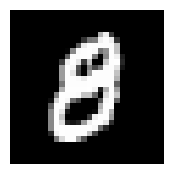

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into vectors of length 784. The images from this dataset are already normalized such that the values are between 0 and 1. 

Here you will build a simple autoencoder. 

The encoder and decoder should be made of simple Multi-Layer Perceptrons. The units that connect the encoder and decoder will be the _compressed representation_ (also called _embedding_).

Since the images are normalized between 0 and 1, you will need to use a **sigmoid activation on the output layer** to get values that match this input value range.

For this exercise you are going to use a dimension for the embeddings of 32.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
#given solution in workspace
class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # Implement an MLP with an input size of 28*28, and an 
        # output layer of size encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, encoding_dim),
            nn.ReLU(),
            nn.BatchNorm1d(encoding_dim),

        )# YOUR CODE HERE
        
        ## decoder ##
        # Implement an MLP with an input layer of size encoding_dim
        # and an output layer of size 28*28
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )# YOUR CODE HERE
        
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input image
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        
        encoded = self.auto_encoder(x)
        
        # Reshape the output as an image
        # remember that the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape((x.shape[0], 1, 28, 28))
    
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)

In [40]:
#my solution, using the given solution for guidance
class Autoencoder(nn.Module):
    
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # Implement an MLP with an input size of 28*28, and an 
        # output layer of size encoding_dim
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
#             nn.Linear(128, 64),
#             nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.BatchNorm1d(encoding_dim)

        )# YOUR CODE HERE
        
        ## decoder ##
        # Implement an MLP with an input layer of size encoding_dim
        # and an output layer of size 28*28
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
#             nn.Linear(128, 256),
#             nn.BatchNorm1d(256),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )# YOUR CODE HERE
        
        self.auto_encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input image
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        
        encoded = self.auto_encoder(x)
        
        # Reshape the output as an image
        # remember that the shape should be (batch_size, channel_count, height, width)
        return encoded.reshape((x.shape[0], 1, 28, 28))
    
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)

---
## Loss Function

As explained in the lesson, we can use the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [16]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop - however, this task is an unsupervised task, which means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

For this simple autoencoder we do not need the GPU, so we will train on the CPU.

In [41]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [42]:
# number of epochs to train the model. Adjust as needed
n_epochs = 20

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|██████████| 12/12 [00:00<00:00, 13.55it/s]


Epoch: 1 	Training Loss: 60.515698	Valid Loss: 35.916094


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.38it/s]


Epoch: 2 	Training Loss: 32.848160	Valid Loss: 28.907146


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.18it/s]


Epoch: 3 	Training Loss: 26.705929	Valid Loss: 23.795104


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.42it/s]


Epoch: 4 	Training Loss: 22.663723	Valid Loss: 20.396642


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.10it/s]


Epoch: 5 	Training Loss: 19.411228	Valid Loss: 17.805638


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.08it/s]


Epoch: 6 	Training Loss: 17.395057	Valid Loss: 16.345292


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.04it/s]


Epoch: 7 	Training Loss: 16.105865	Valid Loss: 15.400431


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.51it/s]


Epoch: 8 	Training Loss: 14.813932	Valid Loss: 14.006399


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.64it/s]


Epoch: 9 	Training Loss: 13.771620	Valid Loss: 13.117744


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.51it/s]


Epoch: 10 	Training Loss: 12.913891	Valid Loss: 12.517550


Validating: 100%|██████████| 12/12 [00:00<00:00, 12.23it/s]


Epoch: 11 	Training Loss: 12.116085	Valid Loss: 11.575221


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.01it/s]


Epoch: 12 	Training Loss: 11.487247	Valid Loss: 11.258915


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.22it/s]


Epoch: 13 	Training Loss: 11.041373	Valid Loss: 10.682152


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.23it/s]


Epoch: 14 	Training Loss: 10.608859	Valid Loss: 10.450277


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.44it/s]


Epoch: 15 	Training Loss: 10.394147	Valid Loss: 10.329677


Validating: 100%|██████████| 12/12 [00:00<00:00, 12.87it/s]


Epoch: 16 	Training Loss: 9.979881	Valid Loss: 9.663511


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.33it/s]


Epoch: 17 	Training Loss: 9.613547	Valid Loss: 9.444800


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.16it/s]


Epoch: 18 	Training Loss: 9.340194	Valid Loss: 9.257942


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.05it/s]


Epoch: 19 	Training Loss: 9.104742	Valid Loss: 9.023000


Validating: 100%|██████████| 12/12 [00:00<00:00, 13.49it/s]

Epoch: 20 	Training Loss: 8.919787	Valid Loss: 8.846940


Experiment with your architecture until you get to a loss that is below 10. 

HINT: use at least two linear layers for the encoder and two for the decoder. Use ReLU activation for all layers except the output layer, where you need to use `nn.Sigmoid`.

## Finding Anomalies
Now that our autoencoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained autoencoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [43]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, _ = data
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].numpy(),
                    'reconstructed': outputs[i].numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████| 10/10 [00:01<00:00,  9.92it/s]


,loss,image,reconstructed
0,0.006551,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0022398268, 0.00060133595, 0.00047546165,..."
1,0.017045,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0024383385, 0.00095129677, 0.0007014186, ..."
2,0.002673,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00034773993, 0.0002513248, 6.3378844e-05,..."
3,0.010983,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00076006306, 0.0001645996, 0.00052051555,..."
4,0.008018,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0005662755, 0.00046910686, 0.00039185965,..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made.

> The output of the following cell is best viewed in Expand mode. To activate this mode, please click on Expand in the lower left of the workspace.

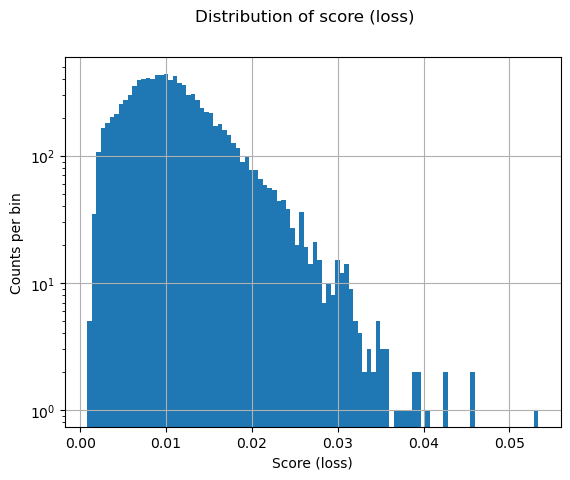

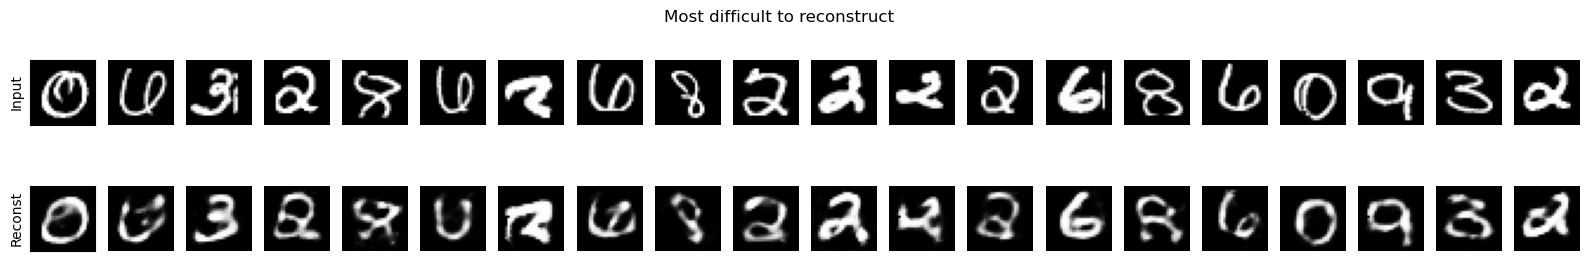

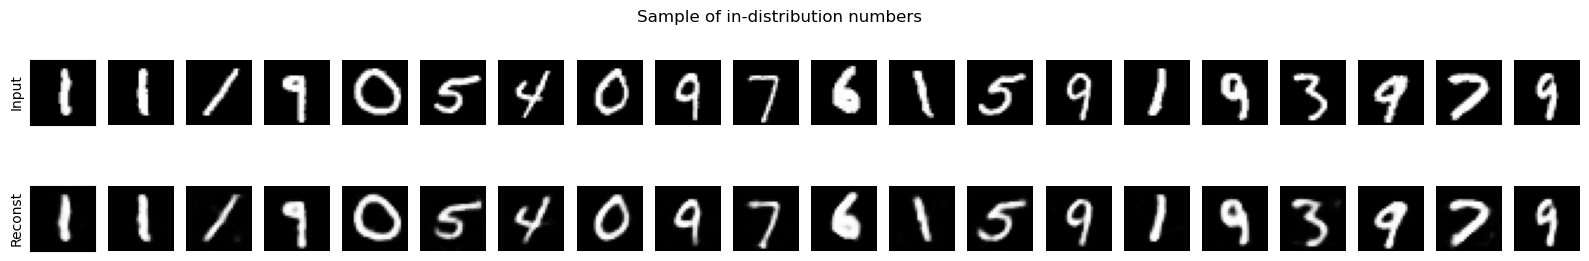

In [44]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

Each of the bottom panels has the input in the first row and the reconstruction in the second row. 

Let's look at the first of the two panels. If your auto-decoder is sufficiently optimized, the most difficult numbers to reconstruct (the "anomalies" with the highest loss) will look pretty particular: they have some noise (like the vertical lines in some of the numbers), or are just not standard ways of drawing the respective numbers. As a result, the reconstructed images (second row) are not matching the inputs very well and the loss is high. These are anomalies.

The second panel instead shows numbers taken from the peak of the distribution, and look indeed much more standard. The autoencoder can reconstruct them much better which results in a lower loss.

In summary, the reconstruction loss can be used as a score proportional to how much a certain example is typical: a low loss means a typical example; a high loss means an atypical example, an anomaly.

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.